In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [9]:
# -----------------------------
# Utilities: unfold_kv (same as earlier)
# -----------------------------
def unfold_kv(x: torch.Tensor, kernel_size: int, padding: int = 0):
    """
    x: (B, H, T, D)
    returns: (B, H, T, kernel_size, D)
    """
    B, H, T, D = x.shape
    x_img = x.permute(0, 1, 3, 2).reshape(B * H, D, 1, T)
    x_unf = F.unfold(x_img, kernel_size=(1, kernel_size), padding=(0, padding), stride=(1, 1))
    x_unf = x_unf.view(B * H, D, kernel_size, T)
    x_unf = x_unf.permute(0, 3, 2, 1).reshape(B, H, T, kernel_size, D)
    return x_unf

# -----------------------------
# RoPE helpers
# -----------------------------
def build_rope_cache(seq_len: int, dim: int, device=None, dtype=torch.float32):
    """
    Build cos and sin caches for RoPE.
    Returns:
      cos: (seq_len, dim//2)
      sin: (seq_len, dim//2)
    Note: dim must be even (we treat pairs).
    """
    assert dim % 2 == 0, "RoPE head dim must be even"
    half = dim // 2
    inv_freq = 1.0 / (10000 ** (torch.arange(0, half, dtype=dtype, device=device) / half))
    positions = torch.arange(seq_len, dtype=dtype, device=device).unsqueeze(1)  # (seq_len,1)
    angles = positions * inv_freq.unsqueeze(0)  # (seq_len, half)
    cos = torch.cos(angles)  # (seq_len, half)
    sin = torch.sin(angles)
    return cos, sin

def apply_rope_to_qk(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor):
    """
    x: (B, H, T, D) where D is even
    cos, sin: (T, D//2)
    returns rotated x of same shape
    """
    B, H, T, D = x.shape
    half = D // 2
    # Split interleaved: even/odd positions along last dim
    x1 = x[..., :D:2]  # (B,H,T,half)
    x2 = x[..., 1:D:2]  # (B,H,T,half)
    # cos/sin -> (1,1,T,half) for broadcasting
    cos_b = cos.unsqueeze(0).unsqueeze(0)  # (1,1,T,half)
    sin_b = sin.unsqueeze(0).unsqueeze(0)
    # rotate
    x1c = x1 * cos_b - x2 * sin_b
    x2c = x1 * sin_b + x2 * cos_b
    # interleave back: [x1c0, x2c0, x1c1, x2c1, ...]
    x_rot = torch.stack([x1c, x2c], dim=-1).reshape(B, H, T, D)
    return x_rot

# -----------------------------
# Hybrid Sparse Attention with RoPE
# -----------------------------
class RoPEHybridSparseAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8, window: int = 4, dropout: float = 0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        head_dim = dim // num_heads
        assert head_dim % 2 == 0, "head_dim must be even for RoPE"
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.window = window
        self.kernel_size = 2 * window + 1

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.out_proj = nn.Linear(dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

        # caches for RoPE will be created on forward based on seq_len

    def forward(self, x: torch.Tensor, global_mask: torch.Tensor = None):
        """
        x: (B, T, D)
        global_mask: (B, T) bool
        returns: out (B, T, D), full_attn (B, H, T, T)  # full_attn is for visualization
        """
        B, T, D = x.shape
        device = x.device
        # 1) project
        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B,H,T,dh)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # 1.5) build RoPE cache and apply to q,k
        cos, sin = build_rope_cache(T, self.head_dim, device=device, dtype=q.dtype)  # (T, dh/2)
        q = apply_rope_to_qk(q, cos, sin)
        k = apply_rope_to_qk(k, cos, sin)

        # 2) extract local windows
        K_windows = unfold_kv(k, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,dh)
        V_windows = unfold_kv(v, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,dh)

        # 3) local scores
        scores_local = torch.einsum("bhtd,bhtwd->bhtw", q, K_windows) / (self.head_dim ** 0.5)  # (B,H,T,win)

        # 4) global part
        if global_mask is None:
            scores_global = None
            K_global = None
            V_global = None
            global_idx_list = [torch.empty(0, dtype=torch.long, device=device) for _ in range(B)]
            global_token_mask = None
        else:
            global_idx_list = []
            maxG = 0
            for b in range(B):
                idx = torch.nonzero(global_mask[b], as_tuple=False).squeeze(-1)
                if idx.numel() == 0:
                    idx = torch.empty(0, dtype=torch.long, device=device)
                global_idx_list.append(idx)
                if idx.numel() > maxG:
                    maxG = idx.numel()

            if maxG == 0:
                scores_global = None
                K_global = None
                V_global = None
                global_token_mask = None
            else:
                # pad to maxG
                K_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device, dtype=q.dtype)
                V_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device, dtype=q.dtype)
                global_token_mask = torch.zeros(B, maxG, dtype=torch.bool, device=device)
                for b in range(B):
                    idx = global_idx_list[b]
                    if idx.numel() == 0:
                        continue
                    kg = k[b, :, idx, :]  # (H, G_b, dh)
                    vg = v[b, :, idx, :]
                    G_b = kg.shape[1]
                    K_global[b, :, :G_b, :] = kg
                    V_global[b, :, :G_b, :] = vg
                    global_token_mask[b, :G_b] = True

                scores_global = torch.einsum("bhtd,bhgd->bhtg", q, K_global) / (self.head_dim ** 0.5)
                # mask padded later

        # 5) combine local and global
        if scores_global is None:
            attn_local = F.softmax(scores_local, dim=-1)
            ctx_local = torch.einsum("bhtw,bhtwd->bhtd", attn_local, V_windows)
            out_heads = ctx_local  # (B,H,T,dh)
            full_attn = torch.zeros(B, self.num_heads, T, T, device=device, dtype=q.dtype)
            # fill local-only full_attn
            for t in range(T):
                left = max(0, t - self.window)
                right = min(T, t + self.window + 1)
                win_len = right - left
                # attn_local[..., t, :win_len] -> place at positions left:right
                full_attn[..., t, left:right] = attn_local[..., t, :win_len]
        else:
            # mask padded global slots
            gmask = global_token_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,G)
            scores_global = scores_global.masked_fill(~gmask, float("-1e9"))

            scores_cat = torch.cat([scores_local, scores_global], dim=-1)  # (B,H,T, win+G)
            attn_cat = F.softmax(scores_cat, dim=-1)
            attn_cat = self.dropout(attn_cat)

            w_local = attn_cat[..., : self.kernel_size]
            w_global = attn_cat[..., self.kernel_size :]

            ctx_local = torch.einsum("bhtw,bhtwd->bhtd", w_local, V_windows)
            ctx_global = torch.einsum("bhtg,bhgd->bhtd", w_global, V_global)
            out_heads = ctx_local + ctx_global

            # build full_attn for visualization
            full_attn = torch.zeros(B, self.num_heads, T, T, device=device, dtype=q.dtype)
            for b in range(B):
                gidx = global_idx_list[b]
                for t in range(T):
                    left = max(0, t - self.window)
                    right = min(T, t + self.window + 1)
                    win_len = right - left
                    # local part
                    full_attn[b, :, t, left:right] = w_local[b, :, t, :win_len]
                    # global part -> assign per actual indices
                    if gidx.numel() > 0:
                        G_b = gidx.numel()
                        full_attn[b, :, t, gidx] += w_global[b, :, t, :G_b]

        # 6) merge heads & out proj
        out = out_heads.permute(0, 2, 1, 3).contiguous().view(B, T, D)
        out = self.out_proj(out)

        return out, full_attn


# -----------------------------
# 2) Small Transformer Encoder block using RoPEHybridSparseAttention
# -----------------------------
class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, window=4, dropout=0.1):
        super().__init__()
        self.attn = RoPEHybridSparseAttention(dim=dim, num_heads=num_heads, window=window, dropout=dropout)
        self.ln1 = nn.LayerNorm(dim, eps=1e-6)
        self.ln2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, global_mask=None):
        # Attention (RoPE + Local+Global)
        residual = x
        x_ln = self.ln1(x)
        attn_out, _ = self.attn(x_ln, global_mask=global_mask)  # attn returns (out, full_attn)
        x = residual + self.dropout(attn_out)

        # MLP
        residual = x
        x_ln2 = self.ln2(x)
        x = residual + self.mlp(x_ln2)
        return x

# -----------------------------
# 3) Encoder-style LLM (small)
# -----------------------------
class SparseRoPEEncoderLM(nn.Module):
    def __init__(self, vocab_size, dim=256, num_heads=8, num_layers=4, mlp_dim=512, window=4, dropout=0.1, tie_word_embeddings=True):
        super().__init__()
        assert dim % num_heads == 0
        self.vocab_size = vocab_size
        self.dim = dim
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.layers = nn.ModuleList([
            EncoderBlock(dim=dim, num_heads=num_heads, mlp_dim=mlp_dim, window=window, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.ln_final = nn.LayerNorm(dim, eps=1e-6)
        self.lm_head = nn.Linear(dim, vocab_size, bias=False)
        if tie_word_embeddings:
            # weight tying
            self.lm_head.weight = self.token_emb.weight

    def forward(self, input_ids, global_mask=None, return_attn=False):
        """
        input_ids: (B, T) long
        global_mask: (B, T) bool
        returns: logits (B, T, V) ; optionally optionally return last layer full_attn (B, H, T, T)
        """
        x = self.token_emb(input_ids) * (self.dim ** 0.5)  # scale
        full_attn_last = None
        for layer in self.layers:
            x = layer(x, global_mask=global_mask)
        x = self.ln_final(x)
        logits = self.lm_head(x)  # (B, T, V)
        if return_attn:
            # get full_attn from the last attention module by running one more call to get full_attn
            # (slightly wasteful but useful for visualization)
            # To avoid double-computation, we can call last layer's attn directly on ln input:
            with torch.no_grad():
                # reconstruct last layer's attn input: apply ln on pre-last activation
                pre_last = x  # note: in this simple code we don't have easy access to pre-ln input; skip
                full_attn_last = None
        return logits, full_attn_last


# -----------------------------
# 4) MLM Head Module (BERT style)
# -----------------------------
class RoPEMaskedLMHead(nn.Module):
    """
    BERTスタイルのMLMヘッド。
    Encoderの出力に対して、非線形変換と正規化を行ってから単語予測を行います。
    構成: Linear -> GELU -> LayerNorm -> Linear (Decoder)
    """
    def __init__(self, dim, vocab_size):
        super().__init__()
        self.dense = nn.Linear(dim, dim)
        self.activation = nn.GELU()
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.decoder = nn.Linear(dim, vocab_size, bias=False)

        # 出力層にはバイアス項をつけるのが一般的です
        self.bias = nn.Parameter(torch.zeros(vocab_size))
        self.decoder.bias = self.bias

    def forward(self, features):
        x = self.dense(features)
        x = self.activation(x)
        x = self.layer_norm(x)
        # 射影してLogitsを得る
        x = self.decoder(x)
        return x


# -----------------------------
# 5) Sparse RoPE BERT for Masked LM
# -----------------------------
class SparseRoPEBertForMaskedLM(nn.Module):
    def __init__(self, vocab_size, dim=256, num_heads=8, num_layers=4, mlp_dim=512, window=4, dropout=0.1, tie_word_embeddings=True):
        super().__init__()
        assert dim % num_heads == 0
        self.vocab_size = vocab_size
        self.dim = dim

        # 埋め込み層
        self.token_emb = nn.Embedding(vocab_size, dim)

        # エンコーダー層 (既存のEncoderBlockを使用)
        self.layers = nn.ModuleList([
            EncoderBlock(dim=dim, num_heads=num_heads, mlp_dim=mlp_dim, window=window, dropout=dropout)
            for _ in range(num_layers)
        ])

        # 元のコードにあったEncoder最終段のLNは、MLMヘッド内にLNがあるため
        # ここでは必須ではありませんが、BERTのアーキテクチャに従い
        # エンコーダー出力そのものを安定させるために入れても構いません。
        # 今回はBERT本来の構成に近づけるため、Head側にLNを任せ、ここは削除またはそのままパスします。
        # (ただし、Pre-LN構成の場合は最後にLNを入れるのが通例なので、念のため残しておきます)
        self.ln_final = nn.LayerNorm(dim, eps=1e-6)

        # MLM用ヘッド (Linear -> GELU -> LN -> Linear)
        self.mlm_head = RoPEMaskedLMHead(dim, vocab_size)

        # Weight Tying (埋め込み層と出力層の重み共有)
        if tie_word_embeddings:
            self.mlm_head.decoder.weight = self.token_emb.weight

        # 損失関数
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, global_mask=None, labels=None):
        """
        input_ids: (B, T) - 一部が[MASK]トークンに置き換わっている入力
        global_mask: (B, T) - Global Attentionを使う位置
        labels: (B, T) - MLMの正解ラベル（計算対象外のトークンは -100 にする）
        """
        # 1. Embedding
        x = self.token_emb(input_ids) * (self.dim ** 0.5)

        # 2. Encoder Stack
        for layer in self.layers:
            x = layer(x, global_mask=global_mask)

        # Final Norm (Encoderの出力安定化)
        sequence_output = self.ln_final(x)

        # 3. MLM Head
        prediction_scores = self.mlm_head(sequence_output)  # (B, T, V)

        # 4. Loss Calculation (Optional)
        loss = None
        if labels is not None:
            # CrossEntropyLossは (N, C) と (N) の入力を期待するため、次元を変更
            # -100 のラベルは自動的に無視されます
            loss = self.loss_fct(prediction_scores.view(-1, self.vocab_size), labels.view(-1))

        return prediction_scores, loss

In [5]:
from transformers import AutoTokenizer

# モデルのロード
model_id = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

sentence = "強化学習は非常に奥深く、解決に多くの時間がかかる"

# 1. まずIDに変換する (encode)
token_ids = tokenizer.encode(sentence)

# 2. IDを1つずつ日本語に戻してリストにする (decode)
# これで正しい分割単位が見えます
tokens_readable = [tokenizer.decode([tid]) for tid in token_ids]

print("【正しい分割結果】")
print(tokens_readable)

# 参考: 元の文字化け状態を確認したい場合（tokenizer.tokenizeを直接呼ぶとこうなる）
# print(tokenizer.tokenize(sentence))

【正しい分割結果】
['強', '化学', '習', 'は', '非常に', '奥', '深', 'く', '、', '解決', 'に', '多くの', '時間が', 'かかる']


out.shape= torch.Size([1, 48, 128])
full_attn.shape= torch.Size([1, 8, 48, 48])


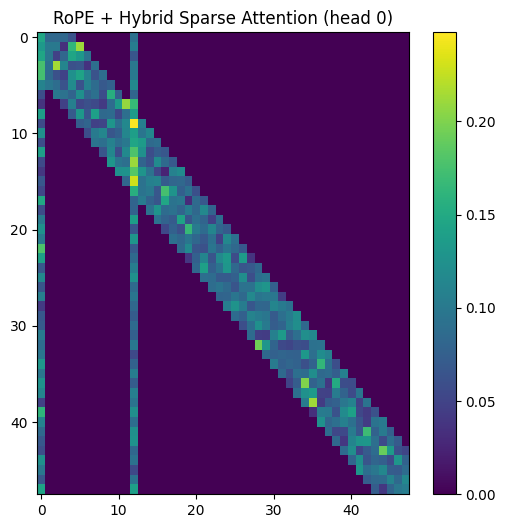

In [3]:
import matplotlib.pyplot as plt

B, T, D = 1, 48, 128
H = 8
window = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

model = RoPEHybridSparseAttention(dim=D, num_heads=H, window=window).to(device)
x = torch.randn(B, T, D, device=device)

# set a couple of global tokens
global_mask = torch.zeros(B, T, dtype=torch.bool, device=device)
global_mask[0, 0] = True
global_mask[0, 12] = True

out, full_attn = model(x, global_mask)
print("out.shape=", out.shape)            # (B,T,D)
print("full_attn.shape=", full_attn.shape)  # (B,H,T,T)

# visualize head 0
att = full_attn[0, 0].detach().cpu().numpy()  # (T,T)
plt.figure(figsize=(6,6))
plt.imshow(att, aspect="auto")
plt.colorbar()
plt.title("RoPE + Hybrid Sparse Attention (head 0)")
plt.show()

In [10]:
print(f"トークナイザ数: {tokenizer.vocab_size}")

model = SparseRoPEBertForMaskedLM(tokenizer.vocab_size)

トークナイザ数: 151643


In [11]:
# モデル設定
vocab_size = 1000
dim = 256
window = 4

model = SparseRoPEBertForMaskedLM(
    vocab_size=vocab_size,
    dim=dim,
    num_heads=8,
    num_layers=4,
    window=window
)

# ダミーデータ (Batch=2, Seq=10)
input_ids = torch.randint(0, vocab_size, (2, 10))

# MLM用のラベルを作成（通常は入力の一部を[MASK]にし、その正解をlabelsに入れる）
# 計算しない場所は -100
labels = input_ids.clone()
labels[:, :5] = -100  # 前半はLoss計算しない

# Forward pass
logits, loss = model(input_ids, labels=labels)

print("Logits shape:", logits.shape)  # (2, 10, 1000)
print("Loss:", loss.item())           # スカラー値

Logits shape: torch.Size([2, 10, 1000])
Loss: 47.99814987182617


In [ ]:
token = ""

from huggingface_hub import login
from datasets import load_dataset

# ここで先ほどコピーしたトークンを入力します
# Google Colabなら notebook_login() を使うと対話的に入力できます
login(token)


In [17]:

# 認証後にロードを実行
# trust_remote_code=True を追加します
dataset = load_dataset(
    "izumi-lab/wikipedia-ja-20230720",
    split="train",
    trust_remote_code=True  # <--- これが必要です
)

print(next(iter(dataset)))

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'izumi-lab/wikipedia-ja-20230720' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'izumi-lab/wikipedia-ja-20230720' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


data/train-00000-of-00008-ff339eae82f3a3(…):   0%|          | 0.00/522M [00:00<?, ?B/s]

data/train-00001-of-00008-98585e12f9cb4e(…):   0%|          | 0.00/275M [00:00<?, ?B/s]

data/train-00002-of-00008-535346ce08c0f0(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

data/train-00003-of-00008-8fac3d2ba4fce8(…):   0%|          | 0.00/226M [00:00<?, ?B/s]

data/train-00004-of-00008-a67f96c8e8620b(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00005-of-00008-9e53198bca3dd4(…):   0%|          | 0.00/216M [00:00<?, ?B/s]

data/train-00006-of-00008-7ff498791eea95(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00007-of-00008-42c5aa7f009169(…):   0%|          | 0.00/214M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1362415 [00:00<?, ? examples/s]

{'curid': '5', 'title': 'アンパサンド', 'text': 'アンパサンド（&amp;, ）は、並立助詞「…と…」を意味する記号である。ラテン語で「…と…」を表す接続詞 "et" の合字を起源とする。現代のフォントでも、Trebuchet MS など一部のフォントでは、"et" の合字であることが容易にわかる字形を使用している。\n語源.\n英語で教育を行う学校でアルファベットを復唱する場合、その文字自体が単語となる文字（"A", "I", かつては " も）については、伝統的にラテン語の "（それ自体）を用いて "A per se A" のように唱えられていた。また、アルファベットの最後に、27番目の文字のように "&amp;" を加えることも広く行われていた。"&amp;" はラテン語で "et" と読まれていたが、後に英語で "and" と読まれるようになった。結果として、アルファベットの復唱の最後は "X, Y, Z, "and per se and"" という形になった。この最後のフレーズが繰り返されるうちに "ampersand" と訛っていき、この言葉は1837年までには英語の一般的な語法となった。\nアンドレ＝マリ・アンペールがこの記号を自身の著作で使い、これが広く読まれたため、この記号が "Ampère\'s and" と呼ばれるようになったという誤った語源俗説がある。\n歴史.\nアンパサンドの起源は1世紀の古ローマ筆記体にまで遡ることができる。古ローマ筆記体では、E と T はしばしば合字として繋げて書かれていた（左図「アンパサンドの変遷」の字形1）。それに続く、流麗さを増した新ローマ筆記体では、様々な合字が極めて頻繁に使われるようになった。字形2と3は4世紀中頃における et の合字の例である。その後、9世紀のカロリング小文字体に至るラテン文字の変遷の過程で、合字の使用は一般には廃れていった。しかし、et の合字は使われ続け、次第に元の文字がわかりにくい字形に変化していった（字形4から6）。\n現代のイタリック体のアンパサンドは、ルネサンス期に発展した筆記体での et の合字に遡る。1455年のヨーロッパにおける印刷技術の発明以降、印刷業者はイタリック体とローマ筆記体のアンパサンドの両方を多用するようになった。アンパサ

In [18]:
# 【重要】Causal LM用のトークナイザには [MASK] トークンがない場合があるため追加する
if tokenizer.mask_token is None:
    tokenizer.add_special_tokens({'mask_token': '[MASK]'})
    print(f"Mask token added: {tokenizer.mask_token} (ID: {tokenizer.mask_token_id})")

Mask token added: [MASK] (ID: 151665)


In [ ]:
# コンテキスト長（モデルに入力する長さ）
block_size = 512

def tokenize_function(examples):
    # テキストカラム名はデータセットによりますが、izumi-labの場合は "text" です
    return tokenizer(examples["text"])

def group_texts(examples):
    # 1. バッチ内のすべてのテキストを結合する
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # 2. block_size の倍数になるように切り詰める
    # (余った半端な部分は捨てる)
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size

    # 3. block_size ごとに分割する
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    # MLMでは "labels" カラムはDataCollatorが自動で作るため、ここではまだ不要
    # ただし、元の input_ids を labels としてコピーしておくとわかりやすい場合もあります
    result["labels"] = result["input_ids"].copy()
    return result

# --- 処理の実行 ---

# 1. まず通常のトークン化
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4, # 並列処理数
    remove_columns=dataset.column_names # 元のテキストカラムは不要になるので削除
)

# 2. 結合して分割 (Chunking)
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=4
)

print(f"加工後のデータ数: {len(lm_datasets)}")
print(f"各データの長さ: {len(lm_datasets[0]['input_ids'])}") # 512になっているはず

Map (num_proc=4):   0%|          | 0/1362415 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling

# MLM用のDataCollatorを作成
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,              # MLMを行うフラグ
    mlm_probability=0.15   # 15%をマスクする（BERTの論文通り）
)

# --- 動作確認 ---
# 実際にどうマスクされるか見てみましょう
from torch.utils.data import DataLoader

dataloader = DataLoader(lm_datasets, batch_size=2, collate_fn=data_collator)
batch = next(iter(dataloader))

# input_ids: マスクされた入力
# labels: 正解（マスクされていない場所は -100）
input_ids = batch["input_ids"][0]
labels = batch["labels"][0]

print("\n--- Masking Check ---")
print("Input IDs (一部):", input_ids[:20])
print("Labels    (一部):", labels[:20])

# デコードして確認（[MASK]が含まれているか見る）
decoded_text = tokenizer.decode(input_ids)
print("\n--- Decoded Text (with Mask) ---")
print(decoded_text[:200]) # 最初の200文字を表示




In [ ]:
# トークン長さをリサイズする
model.resize_token_embeddings(len(tokenizer))